## Group 4

#### Team members:

Arngrímur Einarsson  
Guðmundur Orri Pálsson  
Nick Geertjens  
Stefán Gunnlaugur Jónsson  
Troy Maasland



In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import math
import copy
import enum

class Activation_Function(enum.Enum):
    Relu = 0
    Tanh = 1
    Sigmoid = 2

## Data Processing (Min-Max)

In [ ]:
# Read in training and testing data from excel sheets
data_test = pd.read_excel("HW3Avalidate.xlsx") 
data_train = pd.read_excel("HW3Atrain.xlsx")

X_train = data_train.copy()
X_train = X_train.drop('y', axis=1)
Y_train = data_train.copy()
Y_train = Y_train.drop('X_0', axis=1)
Y_train = Y_train.drop('X_1', axis=1)

X_test = data_test.copy()
X_test = X_test.drop('y', axis=1)
Y_test = data_test.copy()
Y_test = Y_test.drop('X_0', axis=1)
Y_test = Y_test.drop('X_1', axis=1)

# Find the min and max values of each column
x_0_min = min(X_train['X_0'])
x_0_max = max(X_train['X_0'])

x_1_min = min(X_train['X_1'])
x_1_max = max(X_train['X_1'])

# Convert the values in column X based on the Min-Max algorithm
for i in range(len(X_train['X_0'])):
    X_train['X_0'][i] = (X_train['X_0'][i]-x_0_min)/(x_0_max-x_0_min) #formula used for Min-Max
    X_train['X_1'][i] = (X_train['X_1'][i]-x_1_min)/(x_1_max-x_1_min) #formula used for Min-Max
    
for i in range(len(X_test['X_0'])):
    X_test['X_0'][i] = (X_test['X_0'][i]-x_0_min)/(x_0_max-x_0_min) #formula used for Min-Max
    X_test['X_1'][i] = (X_test['X_1'][i]-x_1_min)/(x_1_max-x_1_min) #formula used for Min-Max

training_data = np.empty((0,2), int)
for i in range(len(X_train['X_0'])):
    training_data = np.append(training_data, np.array([[X_train['X_0'][i],X_train['X_1'][i]]]), axis=0)
    
testing_data = np.empty((0,2), int)
for i in range(len(X_test['X_0'])):
    testing_data = np.append(testing_data, np.array([[X_test['X_0'][i],X_test['X_1'][i]]]), axis=0)


y_train = np.empty((0,1), int)
for i in range(len(Y_train['y'])):
    y_train = np.append(y_train, np.array([[Y_train['y'][i]]]), axis=0)

y_test = np.empty((0,1), int)
for i in range(len(Y_test['y'])):
    y_test = np.append(y_test, np.array([[Y_test['y'][i]]]), axis=0)

# Numpy arrays containing our data
np_testing_y = np.array(y_test)
np_testing_x = np.array(testing_data)
np_training_x = np.array(training_data)
np_training_y = np.array(y_train)


## Network Layer Class

In [145]:
class Network_layer:
    
    def __init__(self, number_input, number_neurons, activation_function=Activation_Function.Relu):
        self.weights = np.random.rand(number_input,number_neurons)
        self.bias = np.zeros(number_neurons)
        self.activation_function = activation_function
        self.last_activation = None
        self.error = None
        self.delta = None
        
    def activate(self, x):
        r = np.dot(x, self.weights) + self.bias
        self.last_activation = self.activation(r)
        return self.last_activation
    
    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x, derivative=False):
        if derivative:
            return 1.0 - np.tanh(x)**2
        return np.tanh(x)
    
    def relu(self, x, derivative=False):
        if derivative:
            x[x>0] = 1
            x[x<0] = 0
            return x
        
        x[x<0] = 0
        return x
    
    def activation(self, x):
        
        if self.activation_function == Activation_Function.Relu:
            return self.relu(x)
        if self.activation_function == Activation_Function.Sigmoid:
            return self.sigmoid(x)
        if self.activation_function == Activation_Function.Tanh:
            return self.tanh(x)
        
        return x
    
    def activation_derivative(self, x):
        
        if self.activation_function == Activation_Function.Relu:
            return self.relu(x, True)
        if self.activation_function == Activation_Function.Tanh:
            return self.tanh(x, True)
        if self.activation_function == Activation_Function.Sigmoid:
            return self.sigmoid(x, True)
        
        return x


## Network Net Class

In [ ]:
class Neaural_net:
    layers = []
    
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def feed_forward(self, X):
        for layer in self.layers:
            X = layer.activate(X)
        return X
        
    def checkPrediction(self, y, pred):
        pred = np.around(pred)
        if pred == y:
            return 1
        else:
            return 0 
        
    def mean_square_error(self, y_true, x_predict):
        mse = np.mean(np.square(y_true - NN.feed_forward(x_predict)))
        return mse
    
    def get_batch(self, inputs, targets, batchsize, shuffle=False):
        assert len(inputs) == len(targets)
        if shuffle:
            indices = np.random.permutation(len(inputs))
        for start in range(0, len(inputs) - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start:start + batchsize]
            else:
                excerpt = slice(start, start + batchsize)
            yield inputs[excerpt], targets[excerpt] 
    
    # Backpropagation function used for training
    def backpropagation(self, X, y, learning_rate):
        output = self.feed_forward(X) # Feed forward the whole batch
        correct_predictions = 0
        
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            all_deltas = []
            for j in range(len(output)):
                if layer == self.layers[-1]:
                    layer.error =  y[j] - output[j]
                    all_deltas.append(layer.error * layer.activation_derivative(output[j]))
                    correct_predictions = correct_predictions + self.checkPrediction(y[j], output[j])
                else:
                    next_layer = self.layers[i + 1]
                    layer.error = np.dot(next_layer.weights, next_layer.delta)
                    all_deltas.append(layer.error * layer.activation_derivative(layer.last_activation[j]))
                    
            average_delta = sum(all_deltas)/float(len(output))
            layer.delta = average_delta
    
        # Update the weights
        for j in range(len(output)):
            for i in range(len(self.layers)):
                layer = self.layers[i]
                input_to_use = np.atleast_2d(X[j] if i == 0 else self.layers[i - 1].last_activation[j])
                layer.weights += layer.delta * input_to_use.T * learning_rate
        return correct_predictions

            
    def train(self, X, y, learning_rate, max_epochs, batchsize):
        mses = [] # Mean square errors
        training_accuracy = [] # training accuracy
        
        for i in range(max_epochs):
            correct_per_epoch = 0
            for x_batch,y_batch in self.get_batch(X,y,batchsize=batchsize,shuffle=False):
                correct_predictions_batch = self.backpropagation(x_batch, y_batch, learning_rate)
                correct_per_epoch = correct_per_epoch + correct_predictions_batch
                
            if i % 100 == 0:
                mse = self.mean_square_error(y, X)
                mses.append(mse)
                training_accuracy.append((correct_per_epoch/len(X))*100)
                
        return mses, training_accuracy 
    
    
    # Tests a given input on the network. 
    # Returns accuracy, confusion matrix and mean square error
    def test(self, X, y_true):
        correct = 0
        TT = 0 
        TF = 0
        FT = 0
        FF = 0
        mses = []
        forward_passes = []
        y_truth_values = []
        
        for i in range(len(X)):
            forward_pass = self.feed_forward(X[i])
            
            forward_passes.append(forward_pass)
            y_truth_values.append(y_true[i])
            
            pred = np.around(forward_pass)
            y = y_true[i]
            
            # Computing the confusion matrix
            if pred == y:
                correct = correct + 1
            if pred == 1 and y == 1:
                TT = TT + 1
            if pred == 1 and y == 0:
                FT = FT + 1
            if pred == 0 and y == 1:
                FF = FF + 1
            if pred == 0 and y == 0:
                TF = TF + 1
            confusion = [TT, TF, FT, FF]
            
        mse = np.mean(np.square(np.array(y_truth_values) - np.array(forward_passes))) #Calculate mse
        mses.append(mse)
        
        return correct/len(X), confusion, mses


## Running the Neural Network on our dataset

In [159]:
# Checks if training should stop based on mean square error computed
def should_break(last_mse, mses, lowest_mse, debug, final_round):
    stop = False
    mse_same = True
    stopped_mse = 0
    for i in range(len(last_mse)):
        if round(last_mse[i],4) != round(mses[0],4):
            mse_same = False
    if mse_same:
        if debug or final_round:
            print("MSE has converged! Value has not changed for the last 5 iterations")
        stopped_mse = round(mses[0],4)
        stop = True
    if round(mses[0], 3) < 0.06:
        if debug or final_round:
            print("Error is sufficiently low! Value reached below the selected threshold")
        stopped_mse = round(mses[0],4)
        stop = True
    if round(mses[0],4) - lowest_mse > 0.05:
        if debug or final_round:
            print("MSE increased! Value drastically increased compared to the last value computed")
        stop = True
        stopped_mse = round(mses[0],4)
    return stop,stopped_mse

# Draws a figure
def drawFigure(figure_name,plot_labels, x_axis_data, y_axis_data, x_label, y_label, x_axis_min, x_axis_max, y_axis_min, y_axis_max, number_of_plots):
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(figure_name)
    plt.axis((x_axis_min,x_axis_max,y_axis_min,y_axis_max))
    
    for i in range(number_of_plots):
        plt.plot(x_axis_data[i], y_axis_data[i] , label=plot_labels[i])
      
    plt.legend(loc='best')
    plt.show()
    
def show_desired_results(debug,final_round, graphs_to_show, finished_mse ,iterations, total_training_accuracy, total_training_mse, total_training_times, total_testing_accuracy, total_testing_mse, total_testing_times):
        if debug or final_round:
            print("Training was stopped when mean square error reached", round(finished_mse,4))
        if(graphs_to_show[0]):
            # Draw Comparison of training and testing mse
            plt.subplot(3,1,1)
            drawFigure('MSE training vs. testing', ['MSE: training', 'MSE: testing'], [iterations, iterations], [total_training_mse, total_testing_mse], 'Iterations', 'MSE', iterations[0], iterations[len(iterations)-1], 0, 1, 2)

        # Scale mse to fit figure
        for i in range(len(total_training_mse)):
            total_training_mse[i][0] = total_training_mse[i][0] * 100
            total_training_accuracy[i] = total_training_accuracy[i] * 100
            total_testing_mse[i][0] = total_testing_mse[i][0] * 100
            total_testing_accuracy[i] = total_testing_accuracy[i] * 100
            
        if(graphs_to_show[1]):
            plt.subplot(3,1,2)
            # Draw a figure showing the accuracy and mean square error in training
            drawFigure('Accuracy and MSE in training', ['Accuracy', 'MSE*100'], [iterations, iterations], [total_training_accuracy, total_training_mse], 'Iterations', 'MSE*100 & Accuracy(%)', iterations[0], iterations[len(iterations)-1], 0, 100, 2)
        
        if(graphs_to_show[2]):
            plt.subplot(3,1,3)
            # Draw a figure showing the accuracy and mean square error of a graph
            drawFigure('Accuracy and MSE in testing', ['Accuracy', 'MSE*100'], [iterations, iterations], [total_testing_accuracy, total_testing_mse], 'Iterations', 'MSE*100 & Accuracy(%)', iterations[0], iterations[len(iterations)-1], 0, 100, 2)

#Runs a training on the network based on given values
def run_training(NN, learning_rate = 0.009, batch_size = 5, number_test = 300, number_epoc = 50, showLog=False, graphs_to_show=[True,True,True], final_round=False):

    # Holds the number of iterations
    iterations = []
    
    # Mean square error for the last 5 rounds
    last_mse = [0,0,0,0,0]
    
    # Computer accuracy, time and mse of each training
    total_training_accuracy = []
    total_training_times = []
    total_training_mse = []
    
    # Computer accuracy, time and mse of each training
    total_testing_accuracy = []
    total_testing_times = []
    total_testing_mse = []
    
    # Save the best network
    best_NN = copy.copy(NN)
    
    a = 0
    
    max_accuracy = 0
    lowest_mse = 100
    
    best_confusion = [0,0,0,0]
    best_learning_rate = learning_rate
    recall = []
    precision = []
    
    for i in range(1,number_test+1):
        iterations.append(i*number_epoc)
        
        # Perform training for number_epoc of iterations
        start = time.time()
        training_mse, training_accuracy = NN.train(np_training_x, np_training_y, learning_rate, number_epoc, batch_size)
        end = time.time()
        
        total_training_time = end-start
        
        total_training_accuracy.append(training_accuracy[0]/100)
        total_training_mse.append(training_mse)
        total_training_times.append(total_training_time)

        # Test our network on the test data
        start = time.time()
        testing_accuracy, confusion, testing_mses = NN.test(np_testing_x, np_testing_y)
        end = time.time()
        
        total_testing_time = end-start
        
        total_testing_accuracy.append(testing_accuracy)
        total_testing_mse.append(testing_mses)
        total_testing_times.append(total_testing_time)
        
        # Compute recall
        recall_tmp = round(confusion[0]/(confusion[0]+confusion[3]), 2)
        recall.append(recall_tmp)
        
        # Compute precision
        precision_tmp = round(confusion[0]/(confusion[0]+confusion[2]), 2)
        precision.append(precision_tmp)
        
        # save the last computed mean square error
        last_mse[a] = round(training_mse[0],4)
        
        a = a + 1
        if a > 4:
            a = 0

        if(testing_accuracy > max_accuracy):
            max_accuracy = copy.copy(testing_accuracy)
            best_NN = copy.deepcopy(NN)
            best_confusion = copy.copy(confusion)
            best_learning_rate = copy.copy(learning_rate)
            
        if training_mse[0] < lowest_mse:
            lowest_mse = training_mse[0]
            
        should_show_on_last = False
        
        if final_round and i == number_test:
            should_show_on_last = True

        shouldBreak = False 
        shouldBreak, final_mse = should_break(last_mse, training_mse, lowest_mse,showLog, final_round)  
        final_mse_finished = 0
        
        if i == number_test:
            if showLog or final_round:
                print("Finished all rounds!")
            final_mse_finished = training_mse[0]
        
        if shouldBreak and final_round:
            final_mse_finished = final_mse
            print("SHOW!")
            should_show_on_last = True

        if shouldBreak:
            final_mse_finished = final_mse
            
        
        if showLog or should_show_on_last:
            print('==================================================================================')
            print('Number of iterations finished: ', i*number_epoc, ' -- learning rate: ',learning_rate, ' -- batch size: ', batch_size)
            print('Accuracy')
            print('Testing: ', testing_accuracy, ' Training: ', training_accuracy[0]/100)
            print()
            print('Mean Squared Error')
            print('Testing: ', testing_mses[0], ' Training: ', training_mse[0])
            print()
            print('Time')
            print('Testing: ', total_testing_time, ' Training: ', total_training_time)
            print()
            print('Confusion Matrix')
            print('TrueOne:' , confusion[0])
            print('TrueZero:' , confusion[1])
            print('FalseOne:' , confusion[2])
            print('FalseZero:' , confusion[3])
            print()
            print('==================================================================================')
            
        # Gradually decrease our learning rate
        learning_rate = learning_rate*0.97

        if shouldBreak and final_round:
            break;
        
    show_desired_results(showLog, final_round, graphs_to_show, final_mse_finished, iterations, total_training_accuracy, total_training_mse, total_training_times, total_testing_accuracy, total_testing_mse, total_testing_times)


def init_net(hidden_layers):
    NN = Neaural_net()
    NN.add_layer(Network_layer(2, 10, Activation_Function.Tanh))
    for i in range(hidden_layers - 1):
        NN.add_layer(Network_layer(10, 10, Activation_Function.Tanh))
    NN.add_layer(Network_layer(10,1, Activation_Function.Tanh))
    return NN


NN = init_net(2)
#run_training(NN,showLog=False, graphs_to_show=[True,True,True])

## 1. (10 points) Activation and Loss functions. 
Please choose suitable activation functions φ(0), φ(1), φ(2) and a suitable Loss function to perform the task. Report and justify your choices in the report.

In [ ]:
def tanh(self, x, derivative=False):
        if derivative:
            return 1.0 - np.tanh(x)**2
        return np.tanh(x)

We decided to use the tanh activation function in all the layers, we tried to use sigmoid and ReLu but we got the best results using ReLu. 

To calculate the error we subtracted the output from our net from the true value from the set. Then we used Mean Squared error to determine the net's accuracy. $$MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i-\bar{y}_i)^2$$


## 2. (10 points) Learning rate, batch size, initialization. 
Please choose a suitable learning rate, batch size, initialization of the parameter values, and any other setting you may need. Discuss and justify your choices in the report.

We started with the learning rate as 0.009 and after each test the learning rate was reduced by 1%. We tried various batch sizes, what worked best was relatively small batch sizes so we ended using 
$$batchsize=2$$

When we compared the average running time for each training round using different batch sizes we got the following graph showing that our running time only slightly improved when increasing the batch size.

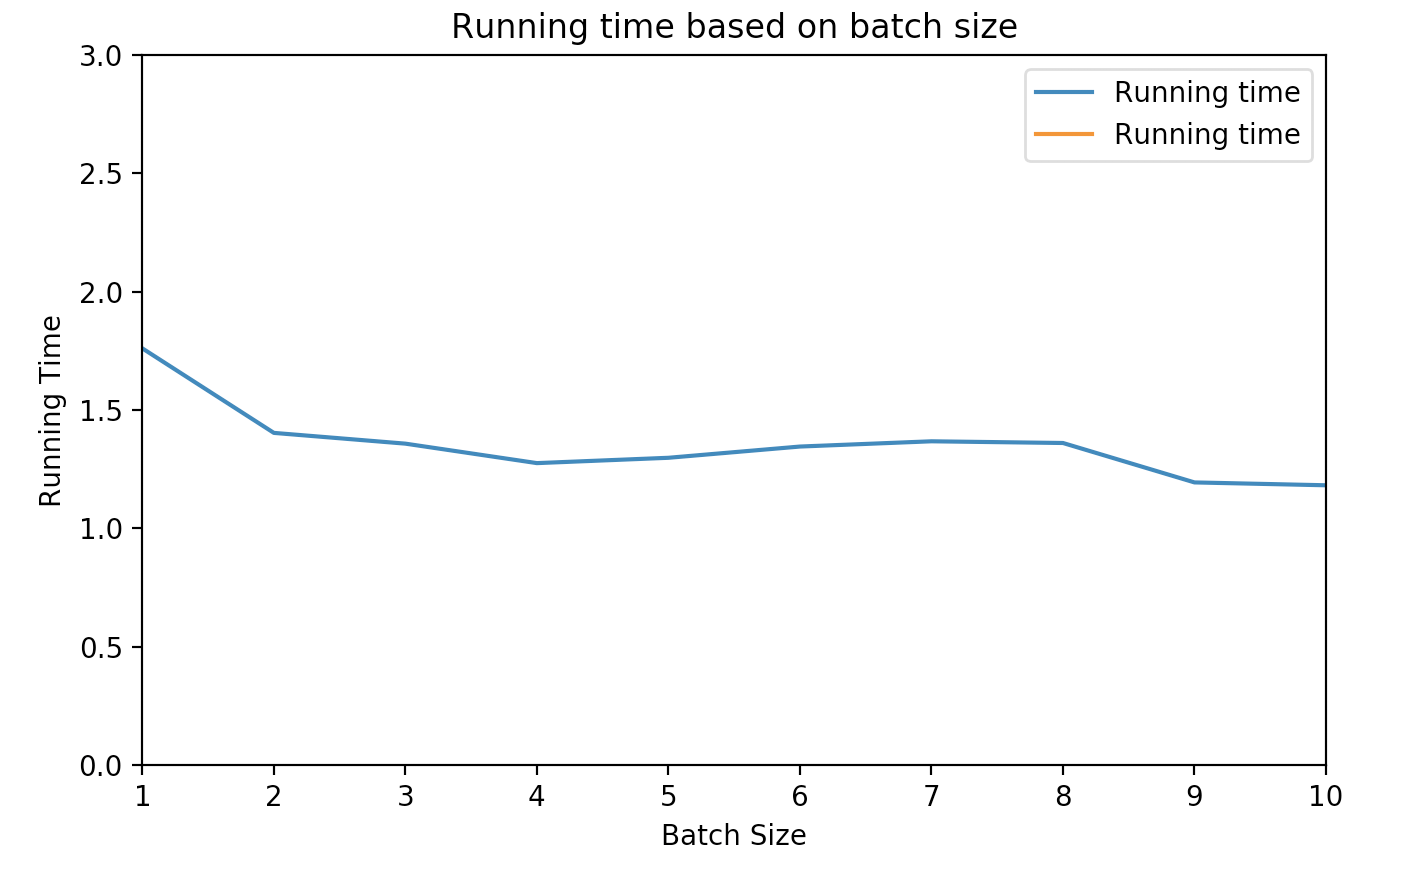

In [141]:
from IPython.display import Image
Image(filename='img.png')

We initialized our weights as a random number from 0 to 1 and our biases as 0. We read that it is best to initialize biases as zero, it also didn´t give good results when we tried random to initilaze the biases. We knew that using random initialization for the weights is better than using zeroes. We tried some other initilizations such as from 0 to 0.5 or -0.5 to 0.5.

## 3. (10 points) Training. 
Make plots with the loss function computed over the training set and over the validation set. Stop the training when the error is small enough. Justify your stopping criterium. Report the final accuracy obtained and the confusion matrix on the validation dataset.

MSE has converged! Value has not changed for the last 5 iterations
SHOW!
Number of iterations finished:  6250  -- learning rate:  0.0002060333663434558  -- batch size:  2
Accuracy
Testing:  0.9024390243902439  Training:  0.924390243902439

Mean Squared Error
Testing:  0.09221686116094013  Training:  0.08066103678626156

Time
Testing:  0.0015230178833007812  Training:  1.048936128616333

Confusion Matrix
TrueOne: 36
TrueZero: 38
FalseOne: 2
FalseZero: 5

Training was stopped when mean square error reached 0.0807


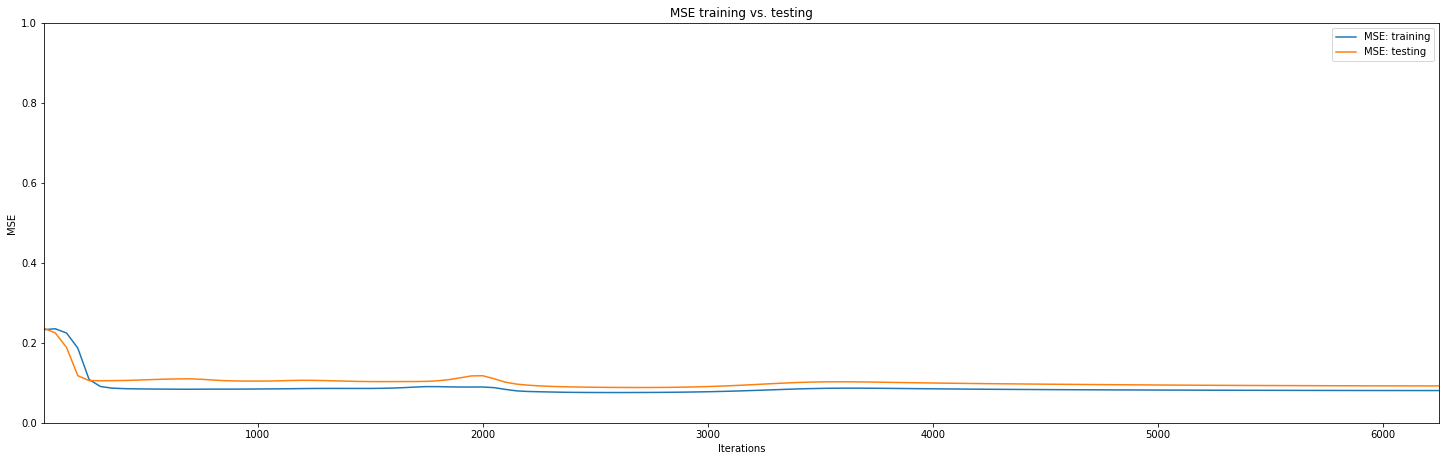

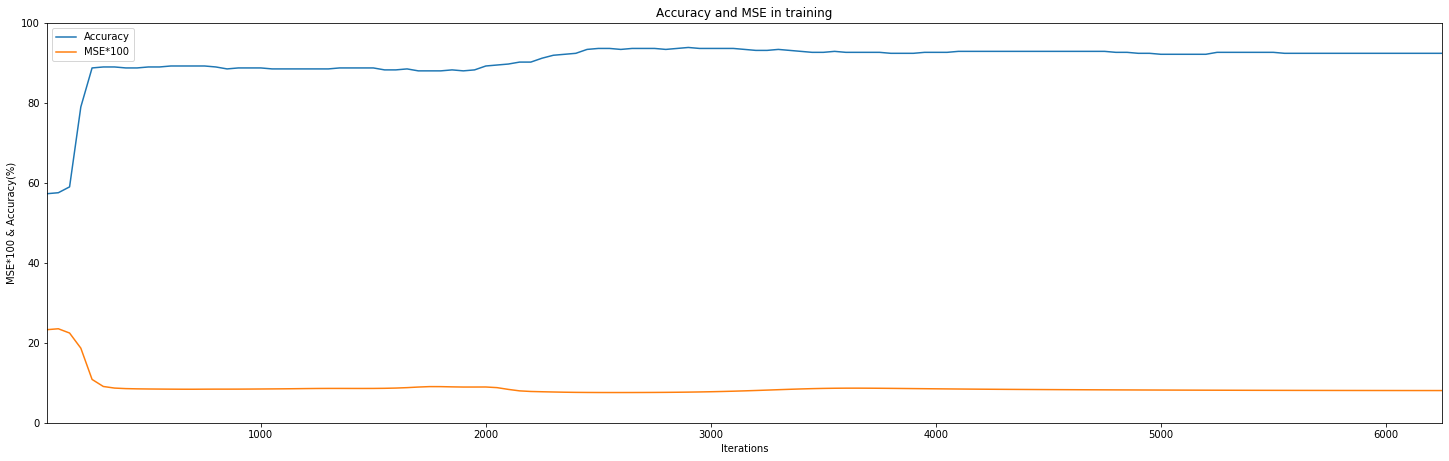

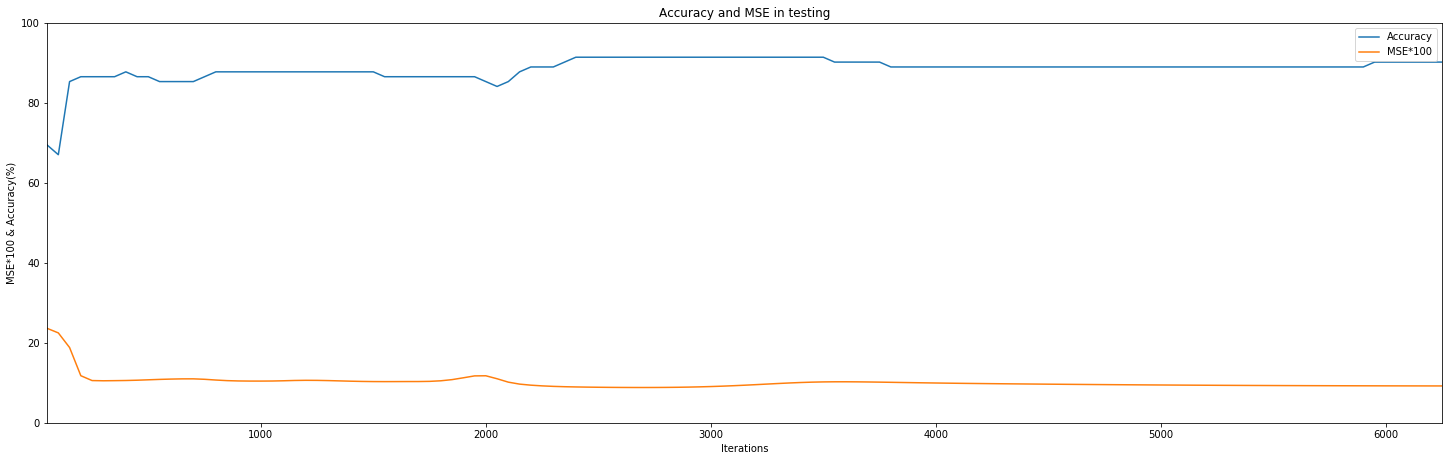

In [160]:
run_training(NN, showLog=False, batch_size=2, graphs_to_show=[True,True,True], final_round=True)

The training stops if any of the following three events occure.  

    i) The mean square error drops below 0.06.  
    ii) The mean square error drastically increases that is MSE_new - MSE_last > 0.06.  
    iii) The mean square error converges and doesn´t change for 5 rounds.  

We get the final confusion matrix: $$\text{Confusion} = \begin{bmatrix} \text{True One} & \text{True Zero} \\ \text{False One} & \text{False Zero} \end{bmatrix} = \begin{bmatrix} 36&38\\2&5
\end{bmatrix}$$

The final accuracy on the validation data is: $$\text{Accuracy} = 90.24\%$$

## 4. (20 points) Implementation. 
We will run and check the uploaded Python file. To obtain the points for this subproblem, the Python file has to run (no errors) and the MLP model and the Backpropagation algorithm have to be implemented completely from scratch by you. You are not allowed to use any library which implements MLP models, but you are allowed to use auxiliary libraries, e.g. Numpy, Matplotlib, Pandas.

Code is above.

## II. Peer Review paragraph (0 points)
Finally, each group member must write a single paragraph outlining their opinion on the work distri- bution within the group. Did every group member contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others?